In [5]:
#the cell for logging in to places
#I could use kaggle secrets but no

In [3]:
#pip installs 
!pip install torch torchxrayvision opacus --quiet
!pip install kagglehub[hf-datasets] --quiet
!pip install pandas --quiet
!pip install qdrant-client --quiet

In [4]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

import os
import matplotlib.pyplot as plt
from PIL import Image

from datasets import Dataset
import pandas as pd

import torch
from torch.utils.data import Dataset as TorchDataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import torch.nn.functional as F
from transformers import CLIPModel, CLIPProcessor, AdamW
from huggingface_hub import login
from tqdm import tqdm

In [6]:
#Downloading the cheXpert dataset

import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "train.csv"

# Load the latest version
hf_dataset = kagglehub.load_dataset(
  KaggleDatasetAdapter.HUGGING_FACE,
  "ashery/chexpert",
  file_path,
  # Provide any additional arguments like 
  # sql_query, hf_kwargs, or pandas_kwargs. See 
  # the documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterhugging_face
)

print("Hugging Face Dataset:", hf_dataset)

<ipython-input-6-cefd6f242c4e>:10: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  hf_dataset = kagglehub.load_dataset(


Hugging Face Dataset: Dataset({
    features: ['Path', 'Sex', 'Age', 'Frontal/Lateral', 'AP/PA', 'No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices'],
    num_rows: 223414
})


In [7]:
def generate_text_descriptions(dataframe):
    """
    Because I am trying to  create a multimodal search system, textual descriptions need to be generated
    also. This is done by looking at the 0 and 1 tags in each column and if the tag is 1, then 
    you add that column name to the text descriptor. This approach should yield some results?
    Obviously the column path is excluded from the descriptors
    """
    descriptions = []
    for index, row in dataframe.iterrows():
        positive_labels = []
        demographic_info = []

        # Extract disease labels
        for column, value in row.items():
            if value == 1 and column not in ['Path', 'Sex', 'Age', 'Frontal/Lateral', 'AP/PA']:
                positive_labels.append(column.replace('_', ' '))

        # Extract demographic and view information
        sex = row['Sex']
        age = row['Age']
        frontal_lateral = row['Frontal/Lateral']
        ap_pa = row['AP/PA']

        demographic_info.append(f"Sex: {sex}")
        demographic_info.append(f"Age: {age}")
        demographic_info.append(f"View: {frontal_lateral}, {ap_pa}")

        # Combine disease labels and demographic info
        if 'No Finding' in positive_labels and len(positive_labels) == 1:
            description = 'No Finding, ' + ', '.join(demographic_info)
        else:
            description = ', '.join(positive_labels + demographic_info)

        descriptions.append(description)

    dataframe['Descriptors'] = descriptions
    return dataframe

In [8]:

"""
In this cell I remove the extra string 'CheXpert-v1.0-small/' from every
path. I do it because if left untouched it messes up the file structure and nothing really works.
After that I generate the textual descriptors for each image
The final step is selecting only the necessary columns for training
"""

#This is the base directory where the Dataset object is stored
base_dir = '/kaggle/input/chexpert'

#Convert Dataset to a DataFrame for convenient string replacement
DataFrame = hf_dataset.to_pandas()
DataFrame['Path'] = DataFrame['Path'].str.replace('CheXpert-v1.0-small/', '', regex=False)
DataFrame = generate_text_descriptions(DataFrame)
DataFrame = DataFrame[['Path', 'Descriptors']]
print(DataFrame.columns.tolist())

['Path', 'Descriptors']


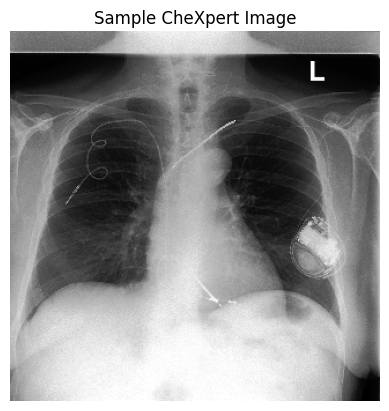

No Finding, Support Devices, Sex: Male, Age: 62, View: Frontal, PA


In [42]:
"""
This cell tests a "random" row from the dataset to confirm my descriptors are logical
I am not a radiologist so there is a little bit of ambiguity here, but I presume 1 means true :)
There are also labels 0 and -1 that appear in the data, but I don't have enough medical expertise
to know what to do with them. I guess the -1 could actually be used for contrastive learning as a
soft negative signal?
"""
pseudo_random_idx = 160

img_path = os.path.join(base_dir, DataFrame['Path'][pseudo_random_idx])
# Open and display the image
image = Image.open(img_path)
plt.imshow(image, cmap='gray')
plt.title("Sample CheXpert Image")
plt.axis('off')
plt.show()

print(DataFrame['Descriptors'][pseudo_random_idx])

In [10]:
"""
This cell curates the training, validation and testing data
"""
HF_data = Dataset.from_pandas(DataFrame)

#This split is approximately 80% training, 10% validation and 10% testing
split_dataset = HF_data.train_test_split(test_size=0.1)
train_valid = split_dataset['train']
test = split_dataset['test']

split_train_valid = train_valid.train_test_split(test_size=0.125)  # 0.125 * 80% ≈ 10% valid
train = split_train_valid['train']
valid = split_train_valid['test']

print("Train size:", len(train), ' ', train)
print("Validation size:", len(valid), ' ',valid)
print("Test size:", len(test), ' ', test)

#prints are looking good

Train size: 175938   Dataset({
    features: ['Path', 'Descriptors'],
    num_rows: 175938
})
Validation size: 25134   Dataset({
    features: ['Path', 'Descriptors'],
    num_rows: 25134
})
Test size: 22342   Dataset({
    features: ['Path', 'Descriptors'],
    num_rows: 22342
})


The final step in data preprocessing is formatting the data into a PyTorch suitable class 

In [11]:
#Image transformations required for CLIP
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # CLIP's normalization values:
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                         std=[0.26862954, 0.26130258, 0.27577711])
])

class CheXpertDataset(TorchDataset):
    def __init__(self, hf_dataset, base_dir, transform, tokenizer):
        self.dataset = hf_dataset
        self.base_dir = base_dir  
        self.transform = transform
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        
        # Construct full image path
        img_path = os.path.join(self.base_dir, item['Path'])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        text = item['Descriptors']
        encoding = self.tokenizer(text, return_tensors='pt', padding='max_length', truncation=True)
        # Remove batch dimension from tokenizer outputs
        for key in encoding:
            encoding[key] = encoding[key].squeeze(0)
        return {
            'pixel_values': image,
            'input_ids': encoding['input_ids'],
            'attention_mask': encoding['attention_mask']
        }

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CLIPModel.from_pretrained('openai/clip-vit-base-patch32')<
processor = CLIPProcessor.from_pretrained('openai/clip-vit-base-patch32')
model = model.to(device)
model.train()  # Set model to training mode

base_dir = '/kaggle/input/chexpert'  

train_dataset = CheXpertDataset(train, base_dir, image_transform, processor.tokenizer)
small_train_dataset = torch.utils.data.Subset(train_dataset, list(range(100)))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
small_train_loader = DataLoader(small_train_dataset, batch_size = 32, shuffle = True)

valid_dataset = CheXpertDataset(valid, base_dir, image_transform, processor.tokenizer)
small_valid = torch.utils.data.Subset(valid_dataset, list(range(2000)))

valid_loader = DataLoader(valid_dataset, batch_size = 32, shuffle = True)
small_valid_loader = DataLoader(small_valid, batch_size = 32, shuffle = True)


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Lets just test that nothing broke during the creation of this

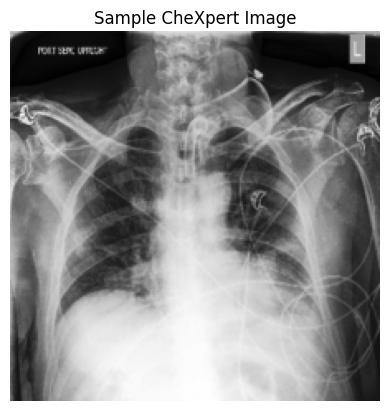

Input IDs: tensor([49406, 16271,   676,  7511,   267,  5937,   281,  2801,   267,   805,
          281,   278,   272,   267,  1093,   281, 35794,   267,  2728, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407])
Attention Mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0])
Decoded Text: lung opacity , sex : male , age : 7 1 , view : frontal , ap


In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Retrieve a single sample from your dataset
sample = train_dataset[0]

# Display the image:
# The image tensor is normalized (using CLIP's values), so we denormalize it for visualization.
image_tensor = sample["pixel_values"]  # Shape: [3, 224, 224]
image_np = image_tensor.cpu().numpy().transpose(1, 2, 0)

# Denormalize the image
mean = np.array([0.48145466, 0.4578275, 0.40821073])
std = np.array([0.26862954, 0.26130258, 0.27577711])
image_np = (image_np * std) + mean
image_np = np.clip(image_np, 0, 1)

plt.imshow(image_np)
plt.title("Sample CheXpert Image")
plt.axis("off")
plt.show()

# Print the tokenized text details:
input_ids = sample["input_ids"]
attention_mask = sample["attention_mask"]
print("Input IDs:", input_ids)
print("Attention Mask:", attention_mask)

# Optionally decode the tokenized text to check its content:
decoded_text = processor.tokenizer.decode(input_ids, skip_special_tokens=True)
print("Decoded Text:", decoded_text)


#everyhting seems to be looking alright, it is a little hard to verify if I messed up somewhere
#because I lack the medical expertise to really analyze the images, but based on the criteria
#I can assess everything seems to be correct

Everything looks correct. Now we should move on to the training loop :)



In [11]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

num_epochs = 30
optimizer = AdamW(model.parameters(), lr=5e-5)

# Lists to keep track of losses
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    # ----- Training -----
    model.train()  # Set model to training mode
    total_train_loss = 0
    for batch in train_loader:
        pixel_values = batch["pixel_values"].to(device)
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        
        outputs = model(pixel_values=pixel_values,
                        input_ids=input_ids,
                        attention_mask=attention_mask)
        
        logits_per_image = outputs.logits_per_image  # [batch_size, batch_size]
        logits_per_text = outputs.logits_per_text
        
        batch_size = logits_per_image.size(0)
        labels = torch.arange(batch_size, device=device)  # Correct indices
        
        loss_img = F.cross_entropy(logits_per_image, labels)
        loss_text = F.cross_entropy(logits_per_text, labels)
        loss = (loss_img + loss_text) / 2
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(small_train_loader)
    train_losses.append(avg_train_loss)
    
    # ----- Validation -----
    model.eval()  # Set model to evaluation mode
    total_valid_loss = 0
    with torch.no_grad():
        for batch in small_valid_loader:
            pixel_values = batch["pixel_values"].to(device)
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            
            outputs = model(pixel_values=pixel_values,
                            input_ids=input_ids,
                            attention_mask=attention_mask)
            
            logits_per_image = outputs.logits_per_image
            logits_per_text = outputs.logits_per_text
            batch_size = logits_per_image.size(0)
            labels = torch.arange(batch_size, device=device)
            
            loss_img = F.cross_entropy(logits_per_image, labels)
            loss_text = F.cross_entropy(logits_per_text, labels)
            loss = (loss_img + loss_text) / 2
            
            total_valid_loss += loss.item()
    
    avg_valid_loss = total_valid_loss / len(small_valid_loader)
    valid_losses.append(avg_valid_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_valid_loss:.4f}")

# ----- Plotting Loss Curves -----
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


Epoch 1/30, Train Loss: 4.5520, Validation Loss: 2.2079
Epoch 2/30, Train Loss: 3.6309, Validation Loss: 2.1099
Epoch 3/30, Train Loss: 3.2697, Validation Loss: 1.8547
Epoch 4/30, Train Loss: 3.0440, Validation Loss: 1.8515
Epoch 5/30, Train Loss: 2.8709, Validation Loss: 1.7356
Epoch 6/30, Train Loss: 2.7170, Validation Loss: 1.7654
Epoch 7/30, Train Loss: 2.5713, Validation Loss: 1.6945
Epoch 8/30, Train Loss: 2.4236, Validation Loss: 1.6977
Epoch 9/30, Train Loss: 2.2683, Validation Loss: 1.6993


KeyboardInterrupt: 

The below is a TPU training loop

In [23]:
save_directory = "./my_finetuned_clip"

# Save the model and processor locally
model.save_pretrained(save_directory)
processor.save_pretrained(save_directory)

# Now, push the saved model to Hugging Face Hub.
# Set your repository name. Format: "your-username/your-repo-name"
repo_name = "Pekkapuuma/fulldata_for_9_epochs"
model.push_to_hub(repo_name)
processor.push_to_hub(repo_name)

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Pekkapuuma/fulldata_for_9_epochs/commit/ef4362dccfbdb326410e42d06f66897d15472c4b', commit_message='Upload processor', commit_description='', oid='ef4362dccfbdb326410e42d06f66897d15472c4b', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Pekkapuuma/fulldata_for_9_epochs', endpoint='https://huggingface.co', repo_type='model', repo_id='Pekkapuuma/fulldata_for_9_epochs'), pr_revision=None, pr_num=None)

In [45]:
fine_tuned_model = CLIPModel.from_pretrained("Pekkapuuma/fulldata_for_9_epochs")
fine_tuned_processor = CLIPProcessor.from_pretrained("Pekkapuuma/fulldata_for_9_epochs")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
fine_tuned_model.to(device)

# Lists to store the embeddings and decoded texts
image_embeddings_list = []
text_embeddings_list = []
decoded_texts = []

# Run inference for the first 1000 samples to start populating the database for a demo
for i in tqdm(range(1500), desc="Running inference on 1000 samples"):
    sample = train_dataset[i]
    
    # Get the image tensor and add batch dimension
    pixel_values = sample["pixel_values"].unsqueeze(0).to(device)
    
    # Get the tokenized text (input_ids and attention_mask) and add batch dimension
    input_ids = sample["input_ids"].unsqueeze(0).to(device)
    attention_mask = sample["attention_mask"].unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = fine_tuned_model(
            pixel_values=pixel_values,
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
    # Extract embeddings (shape: [1, embed_dim])
    image_embeds = outputs.image_embeds  # [batch_size, embedding_dim]
    text_embeds = outputs.text_embeds    # [batch_size, embedding_dim]
    
    # Append the embeddings (convert to CPU numpy arrays)
    image_embeddings_list.append(image_embeds.cpu().numpy())
    text_embeddings_list.append(text_embeds.cpu().numpy())
    
    # Decode the text for verification
    decoded = fine_tuned_processor.tokenizer.decode(input_ids[0], skip_special_tokens=True)
    decoded_texts.append(decoded)

# Convert list of embeddings into numpy arrays for easier manipulation later
image_embeddings_array = np.vstack(image_embeddings_list)
text_embeddings_array = np.vstack(text_embeddings_list)

Running inference on 1000 samples: 100%|██████████| 1500/1500 [00:31<00:00, 47.93it/s]


In [46]:
client = QdrantClient(url=QDRANT_HOST, api_key=QDRANT_KEY)
collection_name = "xray_embeddings"

# Recreate collection
client.recreate_collection(
    collection_name=collection_name,
    vectors_config=VectorParams(size=512, distance="Cosine")  # assuming embeddings of dimension 512
)

# Prepare points for insertion
points = []
num_samples = len(image_embeddings_array)  # should match text_embeddings_array and decoded_texts
for i in range(num_samples):
    points.append(
        PointStruct(
            id=i,
            vector=image_embeddings_array[i].tolist(),
            payload={
                "text_embedding": text_embeddings_array[i].tolist(),
                "decoded_texts": decoded_texts[i],
                "source": "CheXpert"
            }
        )
    )

# Upsert points into Qdrant
client.upsert(collection_name=collection_name, points=points)
print("Data successfully upserted into Qdrant.")


<ipython-input-46-f70e866d2d80>:5: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  client.recreate_collection(


Data successfully upserted into Qdrant.
